In [75]:
import numpy as np
import matplotlib.pyplot as plt
import os
import pandas as pd


In [2]:
# model parameters and state fns

# ====== MODEL PARAMETERS ====== #
#   - a, b, c, and d are neuron parameters (Izhikevich model)
#   - v_th is the threshold voltage
#   - Cm is the membrane capacitance
#   - K_x is a gain factor
#   - I is the initial current
# ============================== #
def initialize_neuron(neuron_type, neuron_response):
    if neuron_response == 0:
        return {
            'a': 0.025,
            'b': 0.2,
            'c': -65,
            'd': 6,
            'v_th': 0.03,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }
    else:
        return {
            'a': 0.02,
            'b': 0.25,
            'c': -50,
            'd': 1.5,
            'v_th': 0.03,
            'Cm': 1,
            'K_one': 0.7,
            'K_two': 3,
            'neuron_type': neuron_type
        }

# ====== MODEL EQUATIONS ====== #
#   - dv and du are the differential equations for the membrane potential and recovery variable
#   - Use Euler's method to update the state of the neuron
# ============================= #
def update_neuron_state(parameters, v, u, t, dt, I):
    a, b, c, d, v_th, Cm, K_one, K_two, neuron_type = parameters.values()

    if neuron_type == 0:
        dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t] + (K_one / Cm) * I[t]
        du = a * (b * v[t] - u[t])

        if v[t] > v_th:
            v[t] = c
            u[t] += d

        u[t+1] = u[t] + dt * du
        v[t+1] = v[t] + dt * dv

    else:
        dv = (0.04 * v[t]**2) + (5 * v[t]) + 140 - u[t]
        du = a * (b * v[t] - u[t])

        if v[t] > v_th:
            v[t] = c
            u[t] += d


        u[t+1] = u[t] + dt * du
        v[t+1] = v[t] + dt * dv + (K_two / Cm) * (I[t + 1] - I[t])

# ====== SIMULATE NEURON ====== #
#   - Given the type of neuron and parameters, simulate the neuron over 1000 ms
#   - Initialize the membrane potential and recovery variable at t = 0
#   - Return the time and membrane potential
# ============================ #
def neuron_simulate(parameters, dt, total_time, I):
    num_steps = int(total_time / dt)

    v = np.zeros(num_steps)
    u = np.zeros(num_steps)
    time = np.linspace(0, total_time, num_steps)

    v[0] = -65
    u[0] = 0

    for t in range(num_steps - 1):
        update_neuron_state(parameters, v, u, t, dt, I)

    return time, v


In [3]:
# plotting fns

def plot_neuron_results(v, spike_counts_array, total_time, topography_size):
    output_folder = "Output_Data"
    if not os.path.exists(output_folder):
        os.makedirs(output_folder)

    plt.xlabel('Time')
    plt.ylabel('Neuron Output')
    plt.title('Neuron Simulation Results for Each Row')
    plt.show()

    # ====== Create a heatmap ====== #
    plt.imshow(spike_counts_array[:, :len(v)], cmap='viridis', aspect='auto', origin='lower', extent=[0, total_time, 0, topography_size])
    plt.colorbar(label='Neuron Output')
    plt.title('Mechanoreceptor Response Heatmap')
    plt.xticks([])
    plt.yticks([])
    plt.xlabel('Topography Surface Axis')
    plt.ylabel('Topography Surface Axis')
    plt.savefig(os.path.join(output_folder, 'Scanning_Model_Heatmap.png'))
    plt.show()

    # ====== Create a 3D plot of the topography encoding ====== #
    fig = plt.figure(figsize=(10, 12))
    ax = fig.add_subplot(111, projection='3d')
    scaled_down_spike_counts_array = spike_counts_array[:, :len(v)] / 10.0
    x, y = np.meshgrid(np.linspace(0, total_time, len(v)), range(topography_size))
    ax.plot_surface(x, y, scaled_down_spike_counts_array, cmap='viridis')

    z_min = 0 # Set your desired minimum value
    z_max = -100  # Set your desired maximum value
    ax.set_zlim(z_min, z_max)

    plt.xticks([])
    plt.yticks([])
    ax.set_xlabel('Topography Surface Axis')
    ax.set_ylabel('Topography Surface Axis')
    ax.set_zlabel('Neuron Output')
    ax.set_title('Topography Mechanoreceptor Response 3D Plot')
    plt.tight_layout()
    plt.savefig(os.path.join(output_folder, 'Scanning_Model_3D_Plot.png'))
    plt.show()


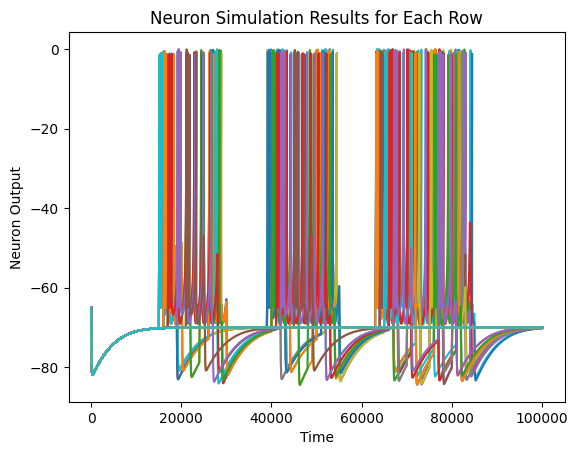

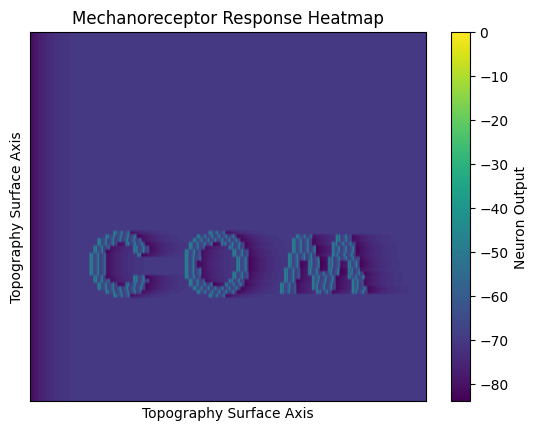

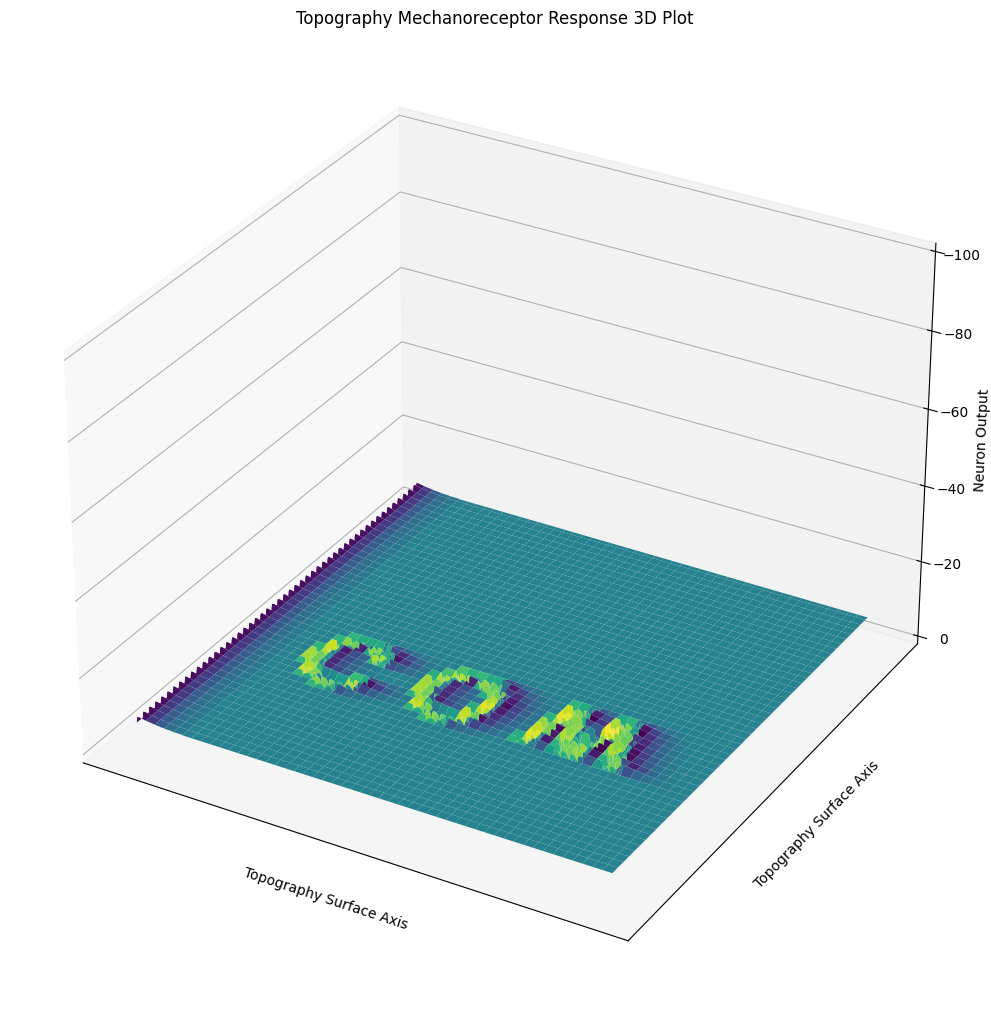

In [6]:
# Neuron type (SA-1 = 0, FA-1 = 1)
neuron_type = 0
# Neuron response (Spiking = 0, Bursting = 1)
neuron_response = 0

topography_size = 100

receptor_resolution = 100000

topography_array = np.loadtxt('Topography_Data/topography_array_output_with_commas.csv', delimiter=',')

spike_counts_array = np.zeros((topography_size, receptor_resolution), dtype=int)

parameters = initialize_neuron(neuron_type, neuron_response)
dt = 0.01
total_time = 1000

for i in range(topography_size):
    selected_row = topography_array[i, :]
    I = np.repeat(selected_row, 1000)
    time, v = neuron_simulate(parameters, dt, total_time, I)
    
    spike_counts_array[i, :len(v)] = v
    
    plt.plot(v, label=f'Row {i + 1}')

plot_neuron_results(v, spike_counts_array, total_time, topography_size)

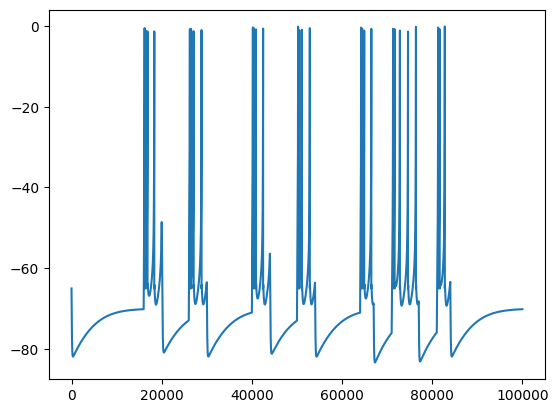

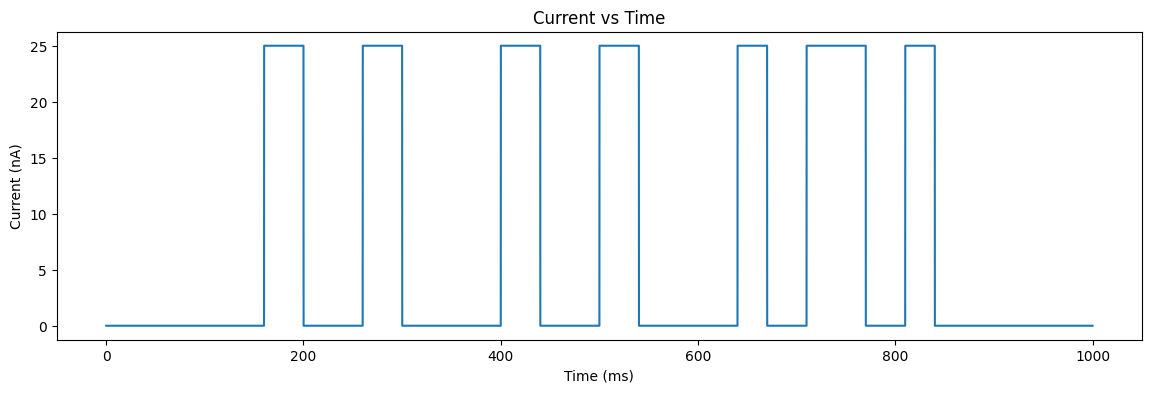

In [7]:
selected_row = topography_array[32, :]
I = np.repeat(selected_row, 1000)
time, v = neuron_simulate(parameters, dt, total_time, I)

spike_counts_array[i, :len(v)] = v

plt.plot(v, label=f'Row {i + 1}')


plt.figure(figsize=(14, 4))
plt.plot(time, I)
plt.title('Current vs Time')
plt.xlabel('Time (ms)')
plt.ylabel('Current (nA)')
# plt.savefig(os.path.join(output_folder, 'Basic_Model_Current_Input.png'))
plt.show()

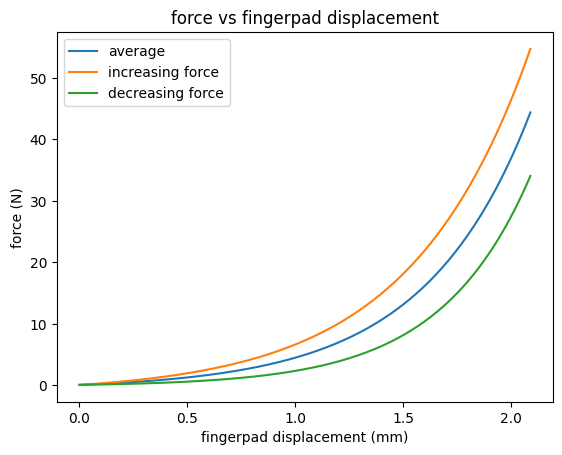

0.0625


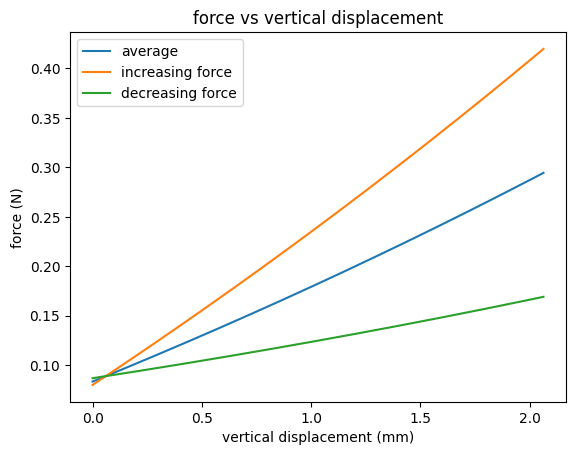

In [125]:
# Force vs displacement methods (exponential functions)
# adapted from Figure 6 of https://ieeexplore.ieee.org/document/5332864

# force and displacement measurements from thumb and index finger


def increasing_displacement(x):
    # constants to adjust exponential function
    a = 1.3
    b = 1.8
    c = 0
    d = -1.22
    return a * np.exp(b * (x - c)) + d

def decreasing_displacement(x):
    # constants to adjust exponential function
    a = 2.5
    b = 2.4
    c = 1
    d = -0.14
    return a * np.exp(b * (x - c)) + d


x = np.arange(0, 2.1, 0.01)

increasing = increasing_displacement(x)
decreasing = decreasing_displacement(x)
average = (increasing + decreasing) / 2

plt.plot(x, average, label="average")
plt.plot(x, increasing, label="increasing force")
plt.plot(x, decreasing, label="decreasing force")
plt.title("force vs fingerpad displacement")
plt.ylabel("force (N)")
plt.xlabel("fingerpad displacement (mm)")
plt.legend()
plt.show()

data = pd.DataFrame({"lateral displacement": x, "force": average})

# get estimated poisson ratio by relating fingerpad displacement to vertical displacement
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4403516/

# assumed displacement vs force values at steady state (t = long time)

# thumb vertical displacement vs force
#  0.2   0.4   0.6   0.8 mm
#  95    126    150   187 mN

# thumb fingerpad poisson ratio
thumb_v = 0.07 / 0.8

# index vertical displacement vs force
#  0.2   0.4   0.6   0.8 mm
#  88    94    104   120 mN

# index fingerpad poisson ratio
index_v = 0.03 / 0.8

# average poisson ratio between the two fingers
avg_v = np.average([thumb_v, index_v])
print(avg_v)

y = np.arange(0, 0.13, 0.001)

increasing_press = increasing_displacement(y)
decreasing_press = decreasing_displacement(y)
average_press = (increasing_press + decreasing_press) / 2

plt.plot(y / avg_v, average_press, label="average")
plt.plot(y / avg_v, increasing_press, label="increasing force")
plt.plot(y / avg_v, decreasing_press, label="decreasing force")
plt.title("force vs vertical displacement")
plt.ylabel("force (N)")
plt.xlabel("vertical displacement (mm)")
plt.legend()
plt.show()

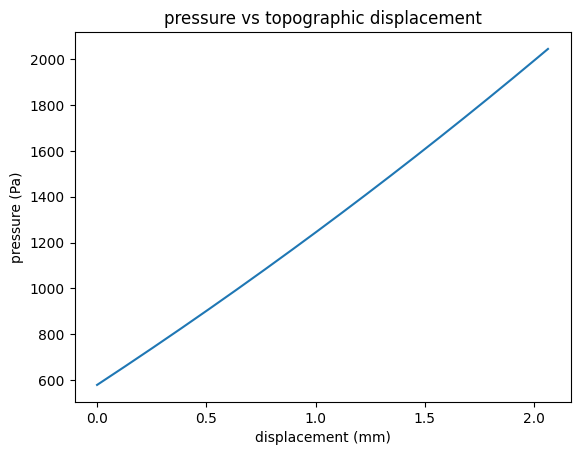

In [131]:
# average fingerpad size is 10-14 mm https://medium.com/@zacdicko/size-matters-accessibility-and-touch-targets-56e942adc0cc#:~:text=An%20MIT%20Touch%20Lab%20study,their%20finger%20pad%20to%20interact.

def pressure_vs_displacement(x, sa = (12E-3)**2):
    avg_force = np.mean([increasing_displacement(x), decreasing_displacement(x)], axis=0)
    # N / m^2 where m^2 is 12 mm * 12 mm
    return avg_force / sa
 
pressure = pressure_vs_displacement(y)

plt.plot(y / avg_v, pressure)
plt.title("pressure vs topographic displacement")
plt.ylabel("pressure (Pa)")
plt.xlabel("displacement (mm)")
plt.show()


At small displacement, the relationship between force (or pressure) and displacement is ~linear at steady state.

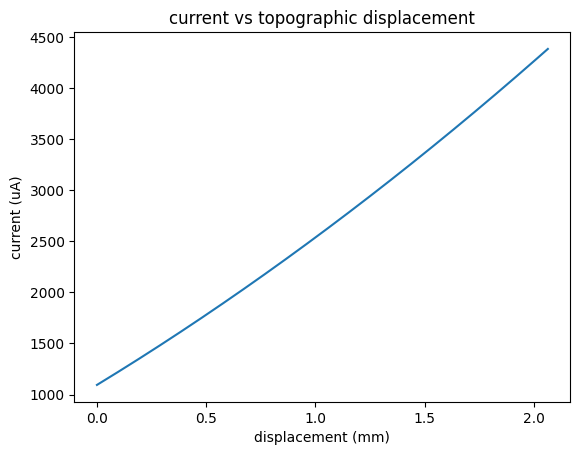

In [139]:
# https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6523954/
# this paper displays pressure vs current relationship of a CNW (carbon nanowall)/PDMS pressure sensor

# to simplify, we will create our own (fake) pressure sensor characteristic that follows an exponential curve

def pressure_to_current(P):
    return P**1.1

plt.plot(y / avg_v, pressure_to_current(pressure))
plt.title("current vs topographic displacement")
plt.ylabel("current (uA)")
plt.xlabel("displacement (mm)")
plt.show()


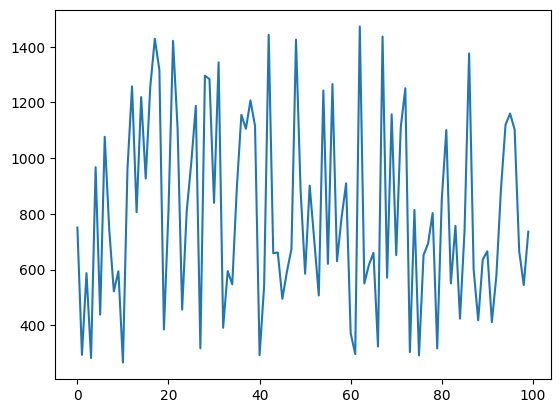

In [138]:
def topography_to_input_current(topography):
    fingerpad_displacement = topography * avg_v
    pressure = pressure_vs_displacement(fingerpad_displacement, (1E-3)**2)
    current = pressure_to_current(pressure)
    return current

random_topography = np.array([np.random.uniform(0, 3) for _ in range(100)])

plt.plot(topography_to_input_current(random_topography) / 1000)
plt.show()